<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [4]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt
plt.rcParams['figure.figsize']=(15, 8)
import scipy.stats as stats
import statsmodels.stats.api as sms

import seaborn as sns

from scipy.stats import bernoulli, beta 

from math import lgamma

import sys
import bayes
%matplotlib inline


In [5]:
# datos
df = pd.read_csv('data/cookie_cats.csv')

In [6]:
# transformacion
df.head(21)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [8]:
df.columns

Index(['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')

In [9]:
data1=df

In [30]:
filas_null=df[df['sum_gamerounds']==0]


In [10]:
# muestreo
df['version'].value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

In [11]:
df.groupby('version')['retention_1'].value_counts()

version  retention_1
gate_30  False          24666
         True           20034
gate_40  False          25370
         True           20119
Name: count, dtype: int64

In [12]:
# muestra para la retencion_1
imps_ctrl, convs_ctrl = 44700, 20034    

imps_test, convs_test = 45489, 20119

In [13]:
# testeo para retention_1
CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas conversion: Control: 0.4481879194630872, Test: 0.44228274967574577'

In [14]:
a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl

a_T, b_T = 1+convs_test, 1+imps_test-convs_test


beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [15]:
# dato muy parecido a la conversion, pero diferente
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [16]:
x=np.linspace(0.4, 0.48, 30)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
        
    plt.legend()
    plt.show();

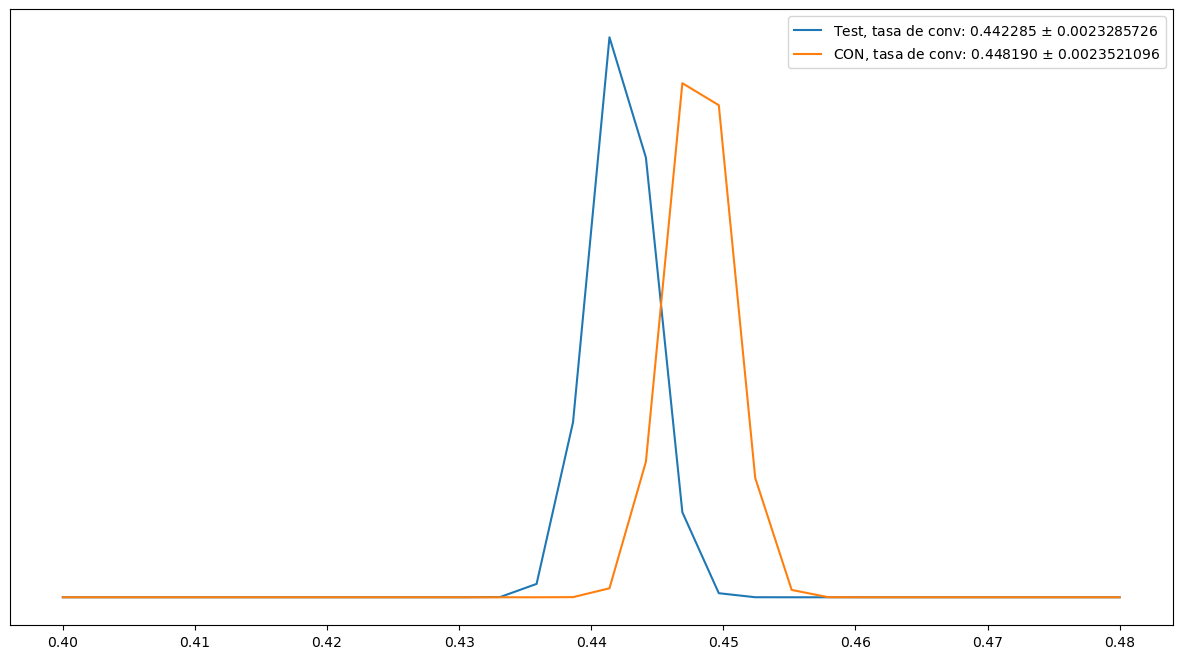

In [17]:
plot([beta_test, beta_control], ['Test', 'CON'])

In [18]:
bayes.calc_prob(beta_control,beta_test)

0.9627939748515354

In [19]:
salto = (beta_control.mean() - beta_test.mean())/beta_control.mean()

salto

0.013175098158249857

In [20]:
# testeo para retention_7

data1.groupby('version')['retention_7'].value_counts()

version  retention_7
gate_30  False          36198
         True            8502
gate_40  False          37210
         True            8279
Name: count, dtype: int64

In [21]:
data1['version'].value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

In [22]:
imps_ctrl, convs_ctrl = 44700, 8502    

imps_test, convs_test = 45489, 8279

In [23]:
CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas conversion: Control: 0.19020134228187918, Test: 0.18200004396667327'

In [24]:
a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl

a_T, b_T = 1+convs_test, 1+imps_test-convs_test


beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [26]:
# dato muy parecido a la conversion, pero diferente
beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [41]:
x=np.linspace(0.16, 0.23, 100)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
        
    plt.legend()
    plt.show();

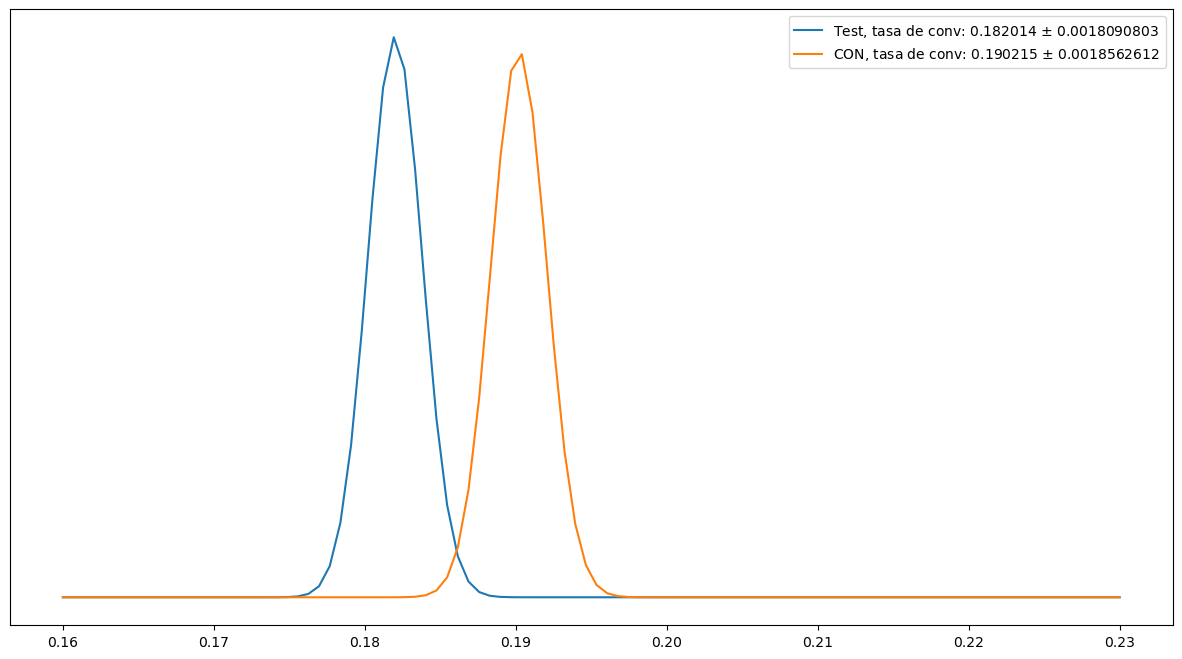

In [42]:
plot([beta_test, beta_control], ['Test', 'CON'])

In [43]:
bayes.calc_prob(beta_control,beta_test)

0.9992226613235504

In [44]:
salto = (beta_control.mean() - beta_test.mean())/beta_control.mean()

salto

0.04311526114658881

# conclusiones
## Retencion 1
### el grupo de control tiene un aumento de la tasa de conversion en un 1,3% con una probabilidad muy alta del 96,27%. 
## Retencion 7
### el grupo de control tiene un aumento de la tasa de conversion en un 4,31% con una probabilidad muy alta del 99,92%

### En conclusion la puerta 30 que es la que ya tienen, funciona mejor en los dos casos 1 dia despues de intalar el juego y 7 dias despues.